In [1]:
#!pip install qulacs
#!pip install matplotlib
#!pip install numpy
#!pip install scipy
from utility import *

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time 
import random
from qulacs import QuantumState
from qulacs import QuantumCircuit
from qulacs.gate import DenseMatrix
from qulacs.circuit import QuantumCircuitOptimizer

#  ラムゼイ干渉をプロットする
- 期待値の直接計算とサンプリングによる計算
- パラメータ付き回路の取り扱い
- ノイズの影響の観察（ノイズのサンプリングには時間がかかる！）

## 直接期待値を計算する

In [3]:
nqubits = 1

#状態の確保
state = QuantumState(nqubits)

#オブザーバブルの定義
measurement = Observable(nqubits)
measurement.add_operator(1.0,"Z 0")

#回転角を定義
theta = np.pi/4

#量子演算を作用
H(0).update_quantum_state(state)
RZ(0,theta).update_quantum_state(state)
H(0).update_quantum_state(state)

#期待値の計算
measurement.get_expectation_value(state)

0.7071067811865471

$\theta$を与えると期待値を計算する関数を定義する

In [4]:
def Ramsay_direct(theta):
    #状態の確保
    nqubits = 1
    state = QuantumState(nqubits)

    #オブザーバブルの定義
    measurement = Observable(nqubits)
    measurement.add_operator(1.0,"Z 0")

    #量子演算を作用
    H(0).update_quantum_state(state)
    RZ(0,theta).update_quantum_state(state)
    H(0).update_quantum_state(state)

    #期待値の計算
    return measurement.get_expectation_value(state)

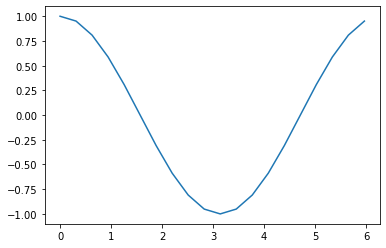

In [5]:
num = 20
angles = [2*np.pi*i/num for i in range(num)]
result = [Ramsay_direct(ang) for ang in angles]
plt.plot(angles,result)
plt.show()

## サンプリングで期待値を推定する

In [6]:
nqubits = 1

#状態の確保
state = QuantumState(nqubits)

#回転角を定義
theta = np.pi/4

#量子演算を作用
H(0).update_quantum_state(state)
RZ(0,theta).update_quantum_state(state)
H(0).update_quantum_state(state)

#サンプリング結果を取得
shots = 10
res = state.sampling(shots)
print(res)

shots = 1000
res = state.sampling(shots)

#平均値の計算
average_value = 0
for i in range(shots):
    average_value += (-2*res[i]+1)/shots    #0,1変数を+1,-1に変換したければ -2x+1 
print(average_value)

[0, 1, 0, 1, 0, 0, 0, 0, 0, 1]
0.7240000000000005


サンプリングによる期待値推定の関数を定義する

In [7]:
def Ramsay_sampling(theta,shots):
    nqubits = 1

    #状態の確保
    state = QuantumState(nqubits)


    #量子演算を作用
    H(0).update_quantum_state(state)
    RZ(0,theta).update_quantum_state(state)
    H(0).update_quantum_state(state)

    #サンプリング結果を取得
    res = state.sampling(shots)

    #平均値の計算
    average_value = 0
    for i in range(shots):
        average_value += (-2*res[i]+1)/shots    #0,1変数を+1,-1に変換したければ -2x+1 
    return average_value

In [8]:
Ramsay_sampling(np.pi/4,10000)

0.6975999999999395

期待値の直接計算(`analytic`)とサンプリング(`sampling`)を比較しておこう

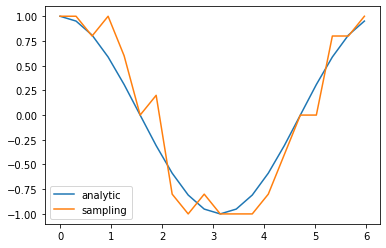

In [9]:
num = 20
shots = 10

angles = [2*np.pi*i/num for i in range(num)]
result1 = [Ramsay_direct(ang) for ang in angles]
result2 = [Ramsay_sampling(ang,shots) for ang in angles]
plt.plot(angles, result1, label="analytic")
plt.plot(angles, result2, label="sampling")
plt.legend()
plt.show()

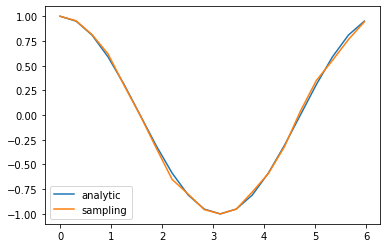

In [10]:
num = 20
shots = 1000

angles = [2*np.pi*i/num for i in range(num)]
result1 = [Ramsay_direct(ang) for ang in angles]
result2 = [Ramsay_sampling(ang,shots) for ang in angles]
plt.plot(angles, result1, label="analytic")
plt.plot(angles, result2, label="sampling")
plt.legend()
plt.show()

## ノイズありのラムゼイ干渉
サンプリングによる統計誤差に加えて、操作におけるノイズをいれてみる。位相回転演算では、回転角$\theta$ に依存して実行時間がかかると考えて、微小回転 delta_theta ごとに delta_gamma の確率で位相緩和を入れることにする。

In [11]:
def noisy_Ramsay_sampling(theta,shots):
    delta_theta = 0.1*np.pi
    delta_gamma = 0.01
    
    nqubits = 1
    #平均値の計算
    average_value = 0
    
    #ノイズのインスタンスは毎回変わるべきなので1回のサンプリングをshots回繰り返す必要がある
    for k in range(shots):
        #状態の確保
        state = QuantumState(nqubits)

        num_rotations = int(theta/delta_theta)

        #量子演算を作用
        H(0).update_quantum_state(state)

        # delta_theta の回転を num_rotations 回繰り返す
        for i in range(num_rotations):
            RZ(0,delta_theta).update_quantum_state(state)
            #確率 delta_gammaでパウリZを作用させて位相を反転する（位相緩和ノイズ）
            if random.random() < delta_gamma:
                Z(0).update_quantum_state(state)

        H(0).update_quantum_state(state)

        #1つだけサンプリング結果を取得
        res = state.sampling(1)

        average_value += (-2*res[0]+1)/shots    #0,1変数を+1,-1に変換したければ -2x+1 
    return average_value

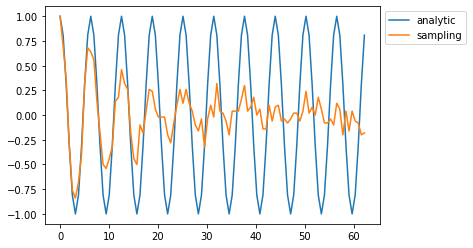

In [12]:
num = 10
shots = 100

angles = [2*np.pi*i/num for i in range(10*num)]
result1 = [Ramsay_direct(ang) for ang in angles]
result2 = [noisy_Ramsay_sampling(ang,shots) for ang in angles]
plt.plot(angles, result1, label="analytic")
plt.plot(angles, result2, label="sampling")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()